# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [2]:
df_agg = pd.read_csv('./data_agg.csv', parse_dates=['Date'])
df_agg.head()

,Date,ID,Age,Sex,PLAQUETAS SANGUE,NEUTRÓFILOS ABSOLUTO,LINFÓCITOS ABSOLUTO,NEUTRÓFILOS %,LINFÓCITOS %
0,2019-04-07 13:36:00,22536285,38.0,0.0,282.0,5.8476,3.1896,44.0,24.0
1,2019-10-12 12:53:00,25368842,7.0,0.0,268.0,5.6057,2.5129,29.0,13.0
2,2019-10-23 14:14:00,25354444,23.0,1.0,426.0,5.1085,0.3606,85.0,6.0
3,2019-10-23 23:08:00,18263638,24.0,0.0,263.0,10.2173,1.1079,83.0,9.0
4,2019-10-23 23:08:00,25384014,70.0,1.0,359.0,5.8940,1.4314,70.0,17.0


In [3]:
columns = df_agg.columns[-7:]
columns

Index(['Age', 'Sex', 'PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO',
       'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %'],
      dtype='object')

# Geração de Amostras Simples: Mistura de Gaussianas

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

Com uma mistura de Gaussianas aplicada aos dados escalados foi possível conseguir resultados próximos dos dados. As curvas de densidade marginal dos dados e das amostras sintéticas estão próximas. O resultado não é totalmente satisfatório porque alguns valores inválidos foram gerados (<0). Os valores das amostras sintéticas foram truncados em zero.

In [5]:
X = df_agg[columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
n_comp = np.arange(1, 31, 2)
bics = []
models = []

for nc in tqdm(n_comp):
    m = GaussianMixture(n_components = nc).fit(X_scaled)
    bics.append(m.bic(X_scaled))
    models.append(m)

n_best = n_comp[np.argmin(bics)]
print(f'Best number of components: {n_best}')
model = models[np.argmin(bics)]

100%|██████████| 15/15 [02:15<00:00,  9.05s/it]

Best number of components: 29


In [7]:
samples, _ = model.sample(10000)
samples_original_scale = scaler.inverse_transform(samples)

samples_original_scale[samples_original_scale < 0] = 0
samples_original_scale[:,1] = samples_original_scale[:,1].round(0)
df_samples = pd.DataFrame(samples_original_scale, columns=columns)

df_samples.to_csv('./data_synthetic.csv', index=False)

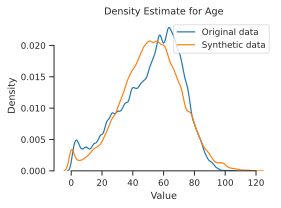

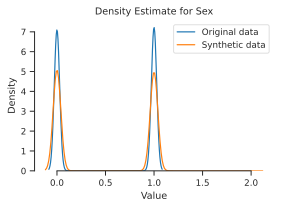

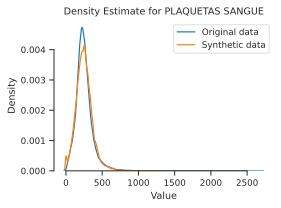

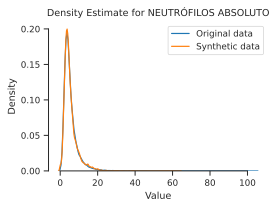

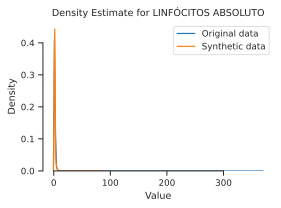

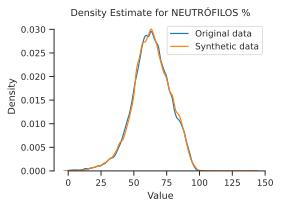

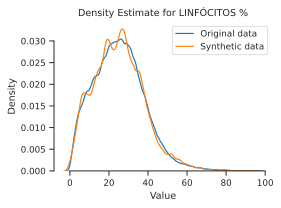

In [9]:
for i, t in enumerate(columns):
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.kdeplot(df_agg[t], label='Original data', ax=ax, bw_adjust=0.5)
    sns.kdeplot(df_samples[t], label='Synthetic data', ax=ax, bw_adjust=0.5)
    ax.set_title(f"Density Estimate for {t}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    plt.tight_layout()
    sns.despine(trim=True)
    plt.savefig(f'./fig/GM_dens_{i}.png')
